### processing pipeline before notebook work

python3 SpikeCounter/cluster/dcimg_folders_to_expt_data.py /n/holyscratch01/cohen_lab/bjia/20211022_widefield_tnnt2aMO_control/

python3 SpikeCounter/cluster/run_preprocess_stim_jobs2.py /n/holyscratch01/cohen_lab/bjia/20211022_widefield_tnnt2aMO_control None --remove_from_start 1 --remove_from_end 20 --n_pcs=40 --scale_factor=2 --skewness_threshold 1 --denoise 1 --decorrelate 1 --start_from_downsampled 0 > jobs.txt

sbatch SpikeCounter/cluster/run_array_autosegmentation.sh /n/holyscratch01/cohen_lab/bjia/20211022_widefield_tnnt2aMO_control/analysis/experiment_data.csv /n/holyscratch01/cohen_lab/bjia/20211022_widefield_tnnt2aMO_control/corrected 0 0 5 3 375 0.01 0.55 0.85 0.15 2.5

In [1]:
import sys
from pathlib import Path
import os
import warnings
SPIKECOUNTER_PATH = os.getenv("SPIKECOUNTER_PATH")
sys.path.append(SPIKECOUNTER_PATH)
from spikecounter.analysis import traces
from spikecounter.ui import visualize
from spikecounter import utils

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from datetime import datetime
import scipy.signal as signal
import scipy.stats as stats
import scipy.interpolate as interpolate
import scipy.optimize as optimize
from scipy.ndimage.filters import uniform_filter1d
import matplotlib.lines as mlines
import matplotlib.colors as colors
import seaborn as sns
import pickle
import os
from scipy.io import savemat
import scipy.io as scio
import colorcet as cc
import importlib
import sys
from pathlib import Path
import os
import warnings
SPIKECOUNTER_PATH = os.getenv("SPIKECOUNTER_PATH")
sys.path.append(SPIKECOUNTER_PATH)
import matplotlib as mpl
from matplotlib import patches, colors
import colorcet as cc
from cycler import cycler

import numpy as np
import skimage.io as skio
from scipy import ndimage, signal, stats, fft, interpolate, optimize
from skimage import exposure, measure, filters, transform, morphology
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import time
import mat73
import pandas as pd
import parse
import pickle

from spikecounter.analysis import traces, images
from spikecounter.ui import visualize, HyperStackViewer
from spikecounter import utils
import seaborn as sns

warnings.filterwarnings("once")
plt.style.use(
    os.path.join(SPIKECOUNTER_PATH, "config", "bio_publications.mplstyle")
)
ss = StandardScaler()

In [3]:
expt_dir_name = "20211022_widefield_tnnt2aMO_control"
rootdir = Path(os.getenv("DATA_ROOTDIR"), expt_dir_name)
output_datadir = Path(os.getenv("ANALYSIS_OUTPUT_ROOTDIR"), "2022 First Heartbeat_Submitted", 
                       "Figures/Data/Figure1/", expt_dir_name)
os.makedirs(output_datadir, exist_ok=True)
subfolder = "corrected"

In [4]:
fs=10.2
start_hpf = 19
expt_info = pd.read_csv(os.path.join(rootdir,"analysis/experiment_data.csv")).sort_values("start_time").reset_index()
start_times = [datetime.strptime(t,"%H:%M:%S") for t in list(expt_info["start_time"])]
offsets = [s - start_times[0] for s in start_times]
offsets = [o.seconds for o in offsets]
expt_info["offset"] = offsets
expt_info["hpf"] = start_hpf + expt_info["offset"]/3600

### Plot masks

In [7]:
reload_libraries()

In [8]:
dobj = traces.TimelapseArrayExperiment(data_dir,start_hpf, fs, block_metadata = expt_info)

In [9]:
def custom_lp_filter(raw, norm_thresh=0.5):
    b, a = signal.butter(5, norm_thresh)
    intensity = signal.filtfilt(b, a, raw)
    mean_freq = 2.0
    b, a = signal.butter(5, [mean_freq-0.2, mean_freq+0.2], btype="bandstop", fs=10.2)
    intensity = signal.filtfilt(b, a, intensity)
    return intensity

In [10]:
with open(os.path.join(data_dir, "usable_files.pickle"), "rb") as f:
    usable_files = pickle.load(f)

In [11]:
usable_indices = []
for fname in usable_files:
    contains_file = expt_info["file_name"].str.contains(fname).to_numpy()
    usable_indices.append(np.argwhere(contains_file).ravel()[0])
usable_indices = np.array(usable_indices)

In [12]:
dobj.load_traces(timepoints=usable_indices, per_trace_start=0, corr_photobleach=False, filter_function=lambda x: x)

In [13]:
dobj.analyze_peaks(threshold="auto", prominence="snr", auto_prom_scale=3, auto_thresh_scale=0.4, \
                   wlen=20, min_width=2, max_width=30, baseline_duration=3000, baseline_start=20000,\
                  excl=1000)

0.007378938093250211 0.016042969637014827
0.006616227945099945 0.01579361956683115
0.006955189166269766 0.01914997209938553
0.008209776149164634 0.018808793886541244
0.00675458646812905 0.02162351597843725
0.0063493421509350206 0.02216958872236635
0.005525216433742893 0.014314162590579506
0.006272475314956119 0.014764620351370786
0.00692083553425751 0.012738211329950398
0.006814066820608519 0.012597160992572319
0.008284479038244297 0.019499437817762078
0.010492427970324738 0.010038472875806006


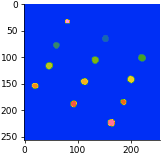

In [19]:
segmentation_mask = skio.imread(os.path.join(data_dir, "segmentation_video.tif"))
roi_map = np.median(segmentation_mask, axis=0)
roi_map = roi_map[np.arange(roi_map.shape[0], step=2),:]
roi_map = roi_map[:,np.arange(roi_map.shape[1], step=2)]
plt.imshow(roi_map)

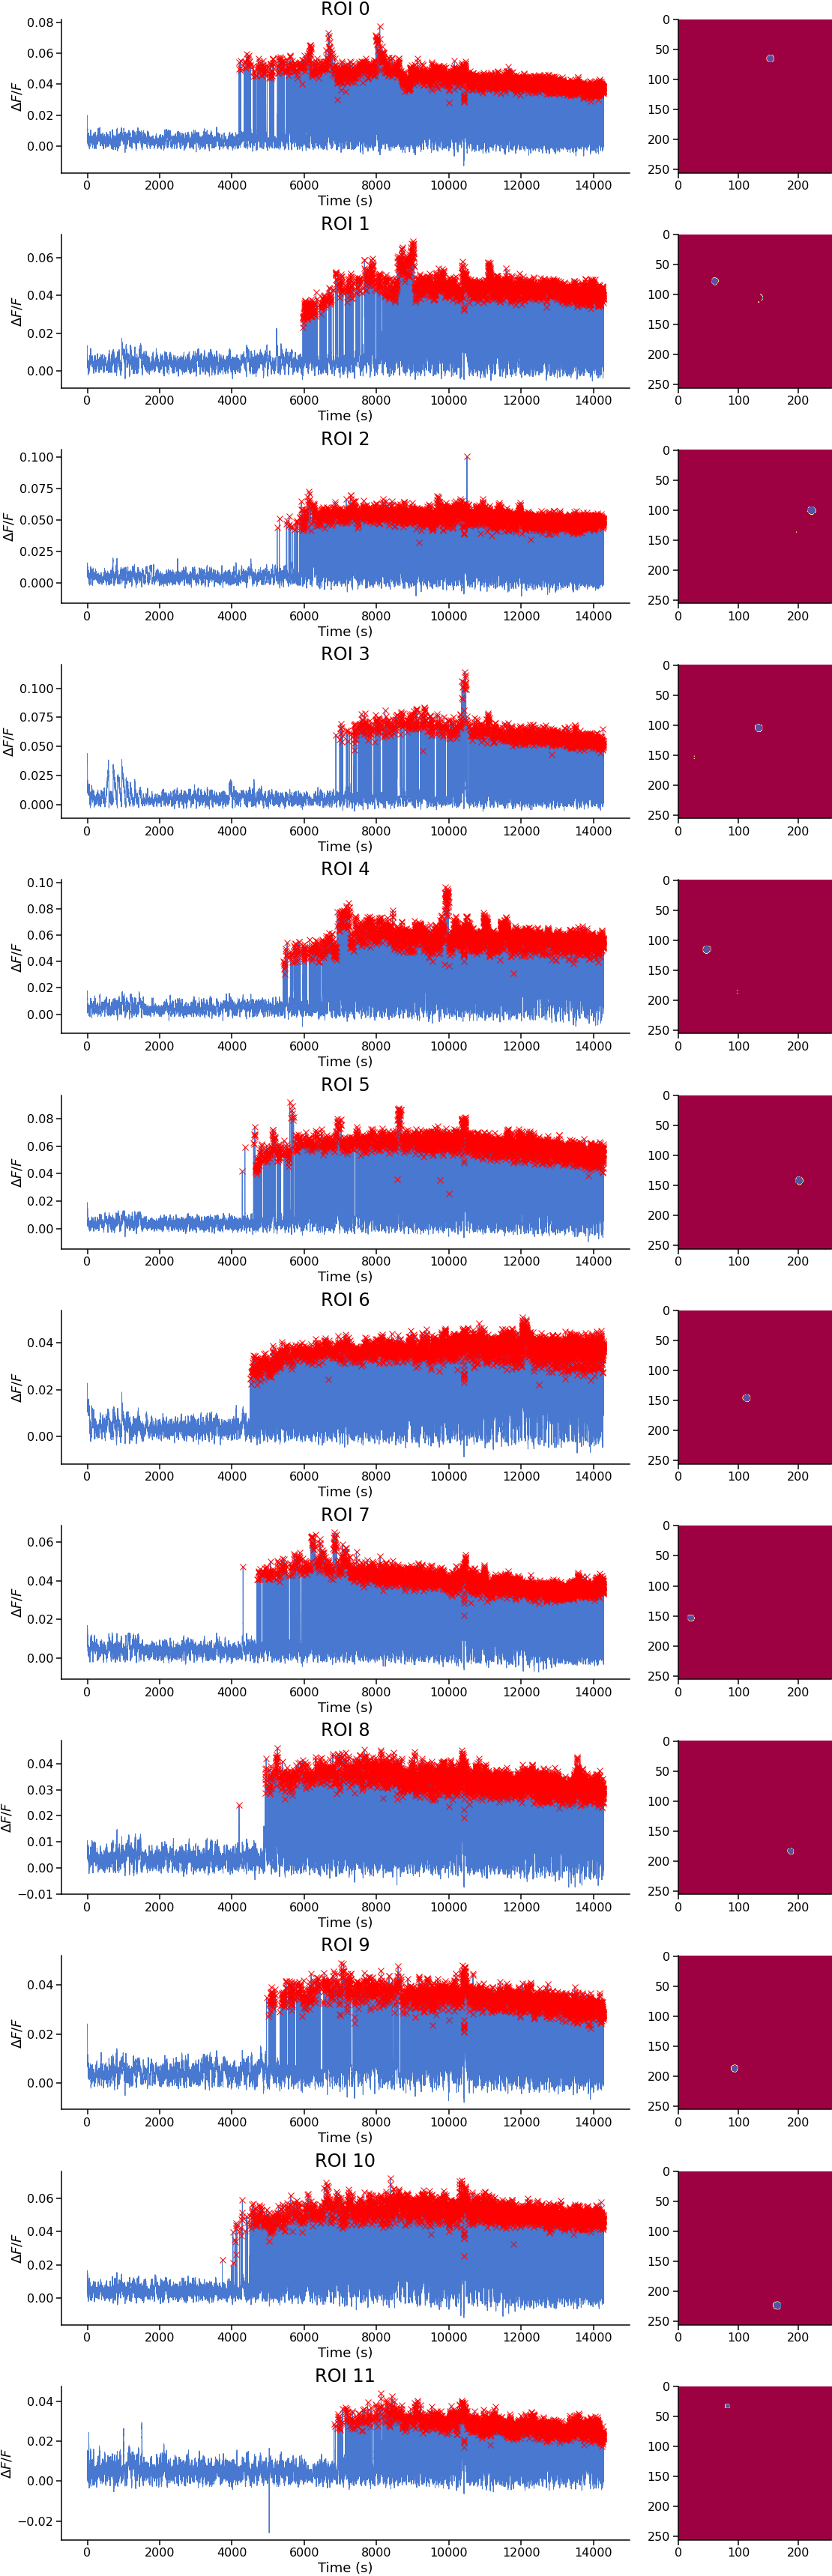

In [30]:
plt.close("all")
fig1, axes = dobj.plot_spikes_with_mask(roi_map)
plt.savefig(os.path.join(data_dir, "spikeplots.svg"))

In [14]:
rois = dobj.peaks_data.index.unique()

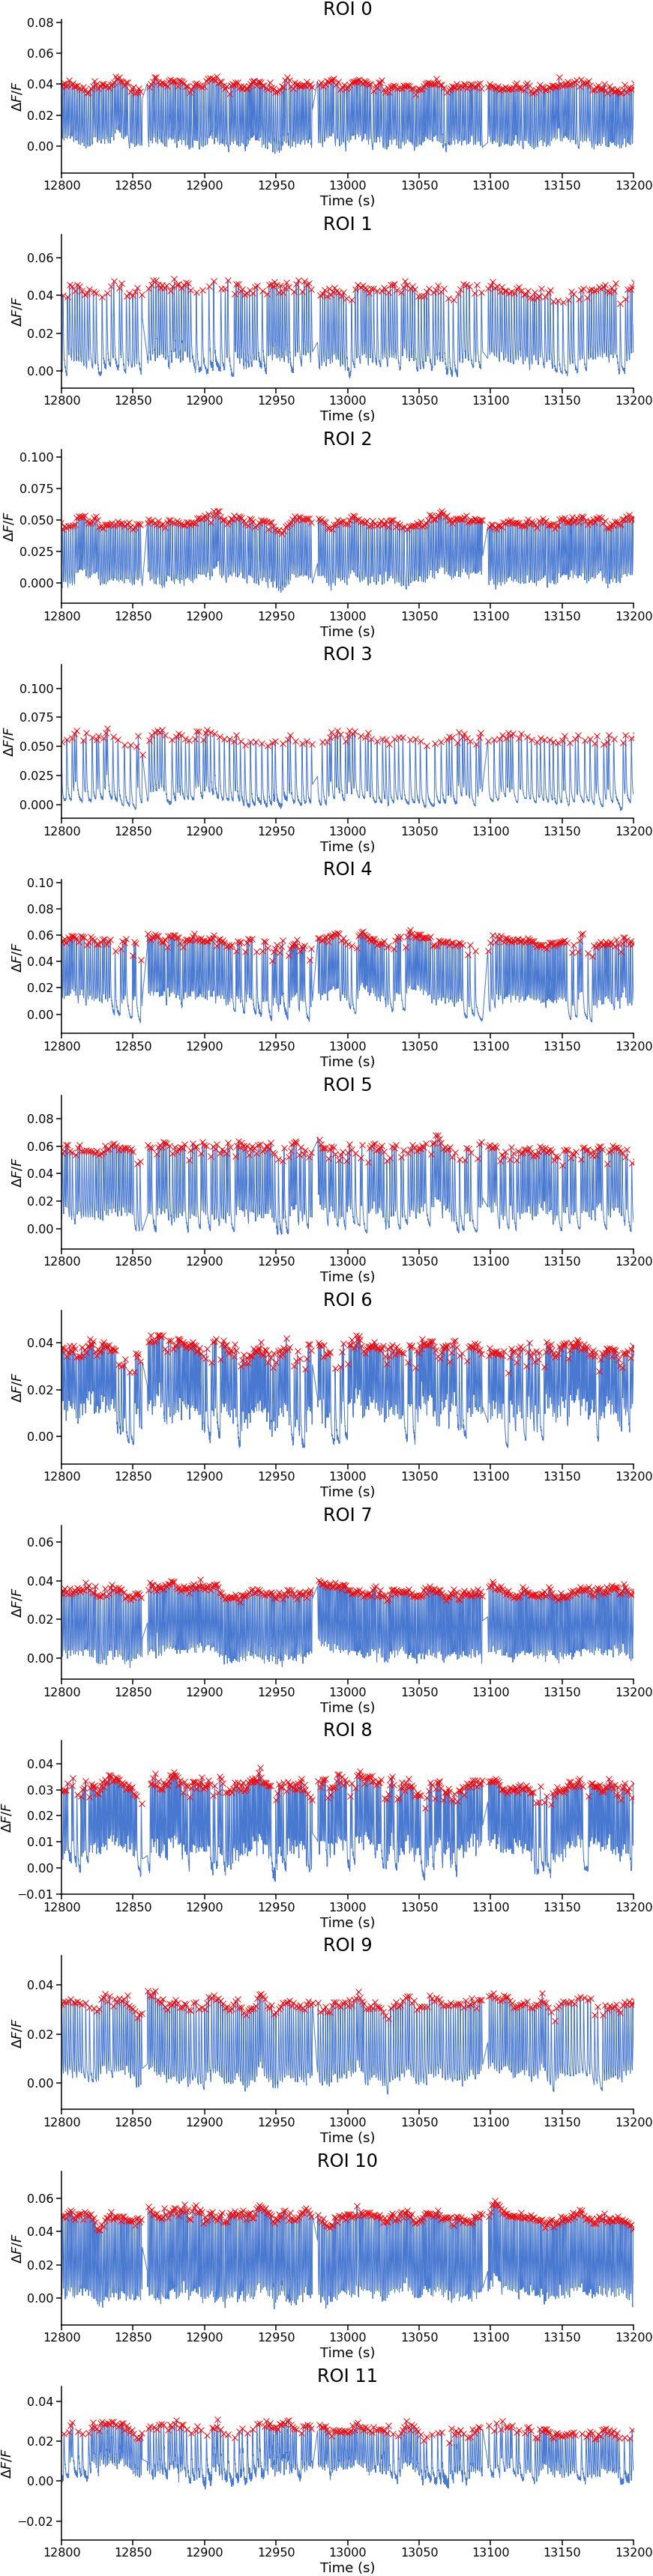

In [19]:
fig1, axes = dobj.plot_spikes(rois)
half_window = 200
midpoint=13000
for idx, roi in enumerate(rois):
    axes[idx].set_xlim((midpoint-half_window, midpoint+half_window))


### Align embryos according to time of first spike

In [40]:
offset_times = []
isi_threshold = 120
rois = dobj.peaks_data.index.unique()
for idx, roi in enumerate(rois):
    roi_data = dobj.peaks_data.loc[roi]
#     print(roi_data["isi"].to_numpy() < isi_threshold)
    isi = roi_data["isi"].to_numpy()
    offset_idx = np.argwhere((isi< isi_threshold)&(np.roll(isi, -1) < isi_threshold)).ravel()[0]
    offset_times.append(roi_data["t"].iloc[offset_idx])

In [41]:
dobj.peaks_data.loc[rois].to_csv(os.path.join(output_data_dir, "peaks_data.csv"))

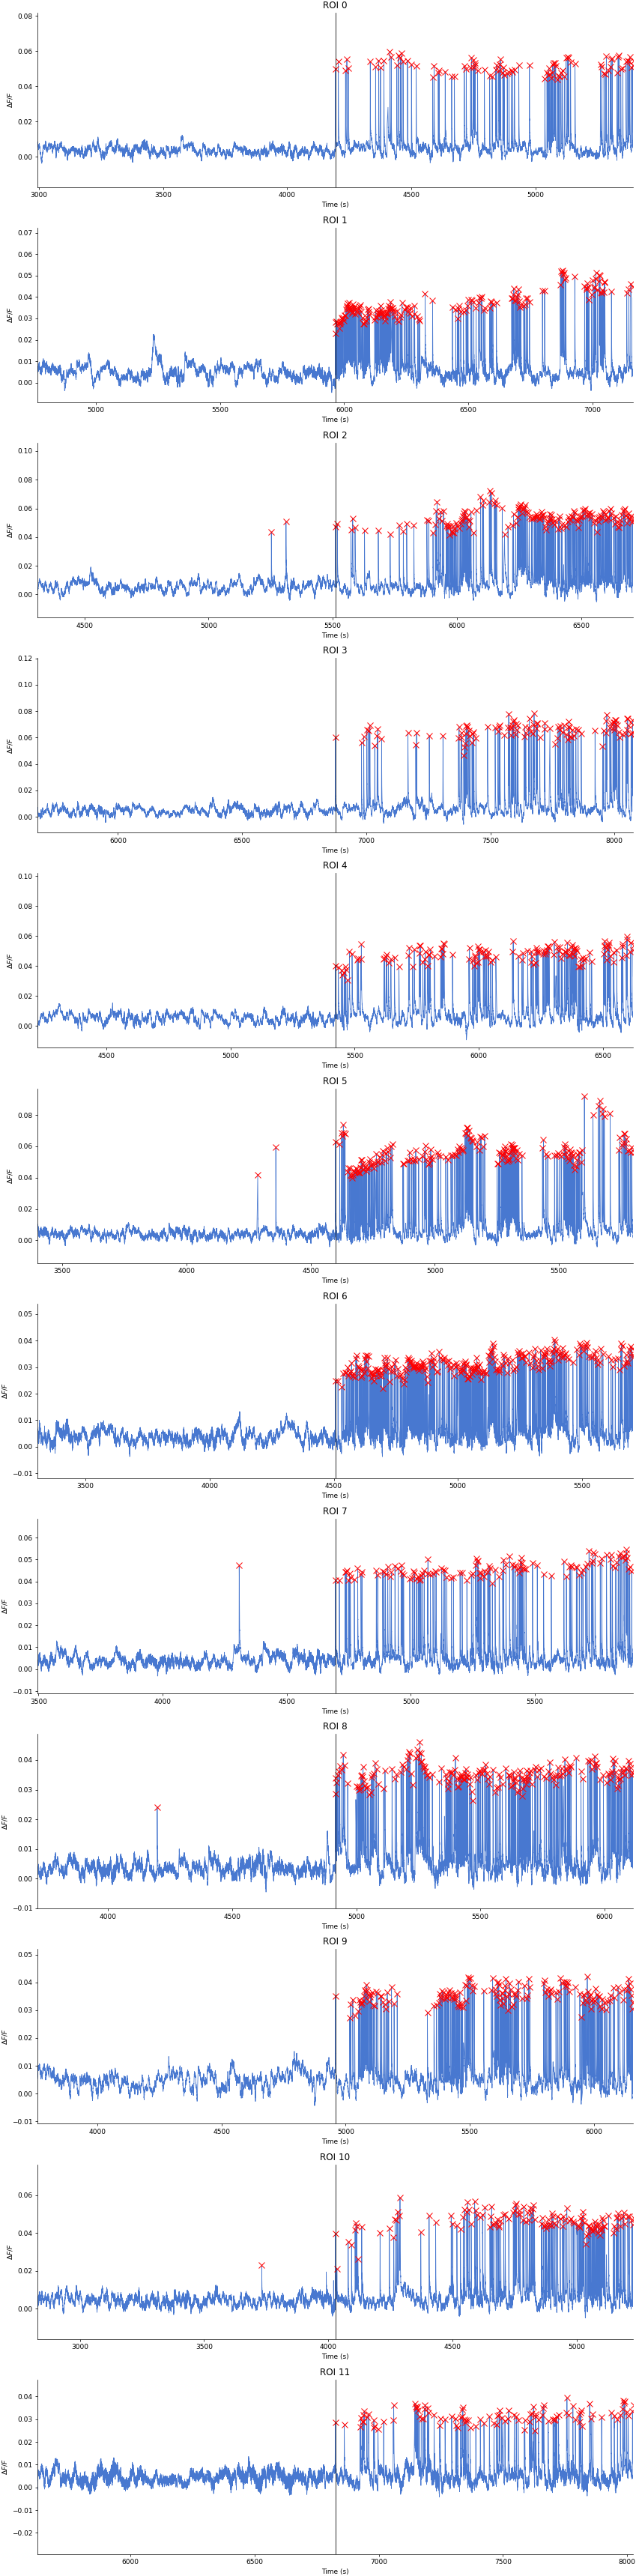

In [42]:
fig1, axes = dobj.plot_spikes(rois)
half_window = 1200
for idx, roi in enumerate(rois):
    axes[idx].set_xlim((offset_times[idx]-half_window, offset_times[idx]+half_window))
    axes[idx].axvline(offset_times[idx], color="black")

### Check frequency change over developmental time for selected embryos

In [38]:
window_size=1800

In [39]:
droi, dsta, dststd = dobj.get_windowed_peak_stats(window_size, overlap=0.9, sta_before=0, sta_after=0, isi_stat_min_peaks=6)

Text(0, 0.5, 'Mean spike frequency (Hz)')

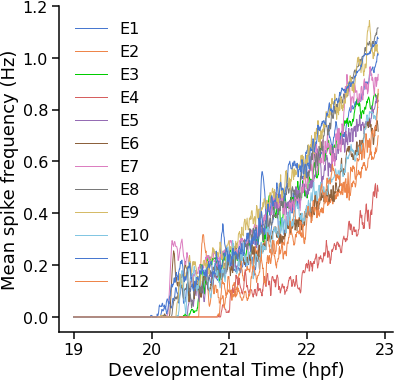

In [45]:
fig1, ax1 = plt.subplots(figsize=(6,6))
for roi in rois:
    e_data = droi.loc[roi]
    ax1.plot(e_data["hpf"], e_data["mean_freq"], label= "E%d" % (roi+1))
ax1.legend()
ax1.set_xlabel("Developmental Time (hpf)")
ax1.set_ylabel("Mean spike frequency (Hz)")

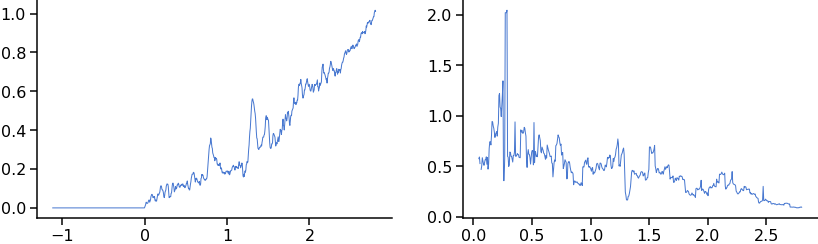

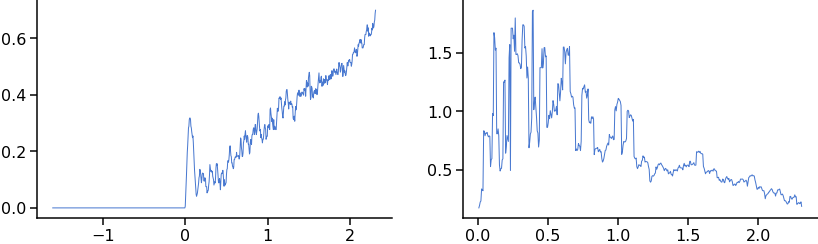

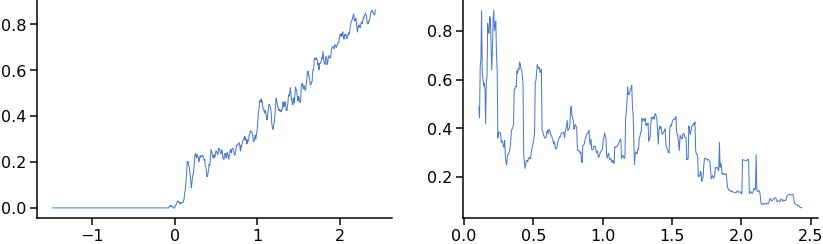

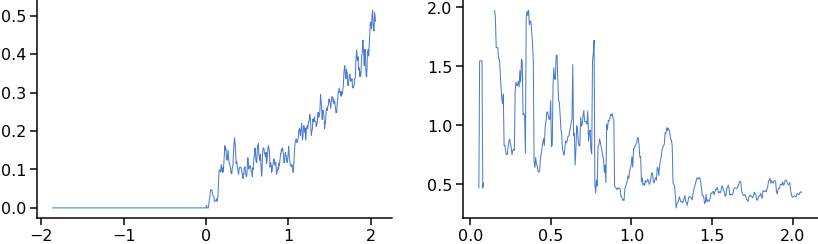

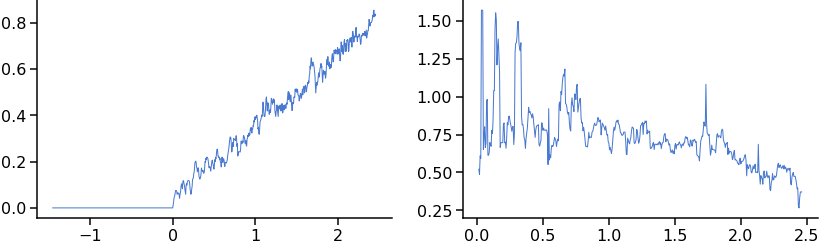

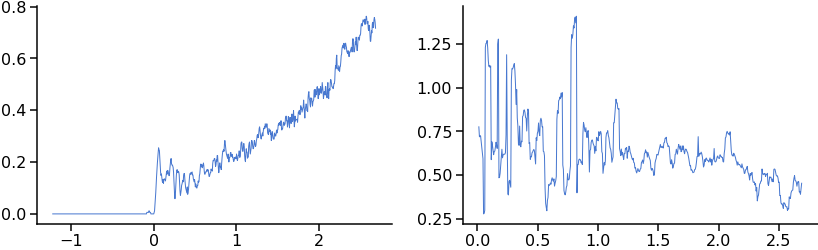

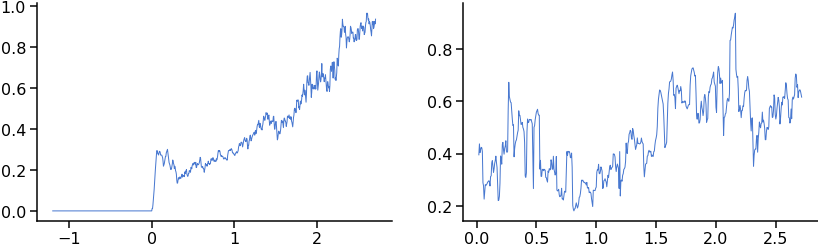

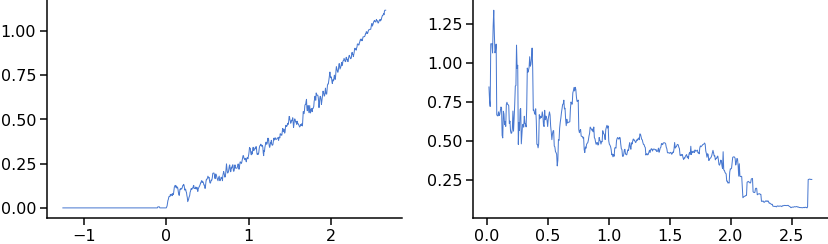

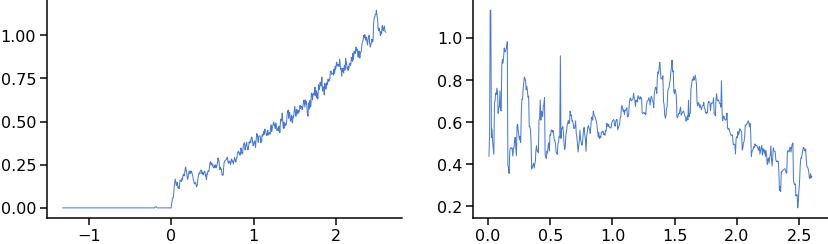

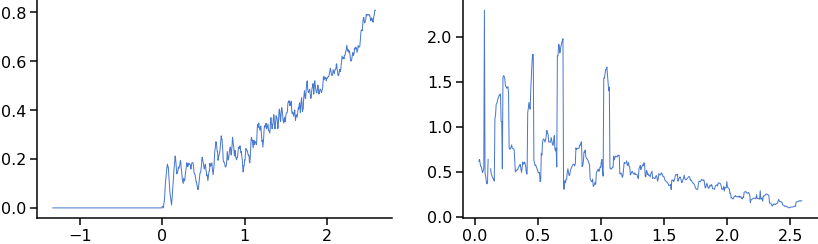

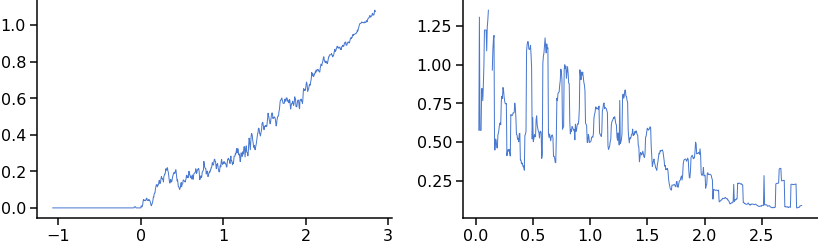

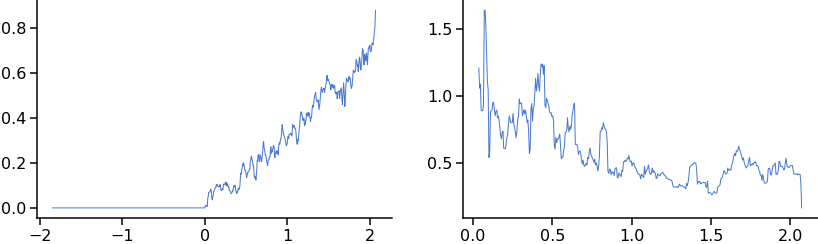

In [53]:
b, a = signal.butter(11, 0.07)
# fig1, axes = plt.subplots(1,2, figsize=(14,6))
for idx, roi in enumerate(rois):
    fig1, axes = plt.subplots(1,2, figsize=(14,4))
    e_data = droi.loc[roi]
    mean_freq = np.array(e_data["mean_freq"])
    hpf = np.array(e_data["hpf"])
    cov = np.array(e_data["std_isi"]/e_data["mean_isi"])

    hpf_offset = dobj.start_hpf + offset_times[idx]/3600 - 0.05
    
    axes[0].plot(e_data["hpf"]-hpf_offset, mean_freq)
    axes[1].plot(e_data["hpf"]-hpf_offset, cov)
#     ax1.plot(e_data["hpf"]-hpf_offset, smoothed_mean_freq, label= "E%d" % (roi+1))

In [43]:
all_offsets = []
for idx, roi in enumerate(rois):
    e_data = droi.loc[roi]
    hpf = np.array(e_data["hpf"])
    all_offsets.append(np.argwhere(e_data["offset"].to_numpy() >= offset_times[idx]).ravel()[0])

/tmp/ipykernel_35128/4073130910.py:34: RuntimeWarning: Mean of empty slice
  mean_freq = np.nanmean(aligned_frequencies, axis=0)
/tmp/ipykernel_35128/4073130910.py:35: RuntimeWarning: Mean of empty slice
  mean_cv = np.nanmean(aligned_covs, axis=0)
/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_35128/4073130910.py:45: RuntimeWarning: Mean of empty slice
  "mean_freq": np.nanmean(aligned_frequencies, axis=0), "hpf":hpf, \


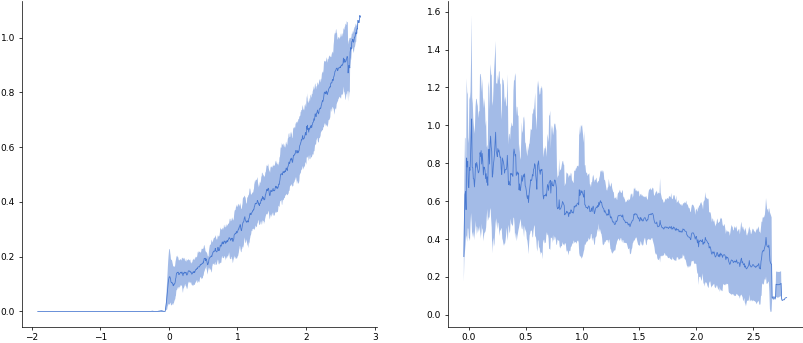

In [44]:
hpf = np.array(droi.loc[0]["hpf"])
hpf_offsets = hpf[all_offsets]
dt = hpf[1] - hpf[0]
aligned_frequencies = np.nan*np.ones((len(rois), \
                                      hpf.shape[0]+max(all_offsets)))
aligned_proms = np.zeros((len(rois), hpf.shape[0]+max(all_offsets)))
aligned_covs = np.nan*np.ones((len(rois), \
                                      hpf.shape[0]+max(all_offsets)))
unaligned_frequencies = np.zeros((len(rois), hpf.shape[0]))
unaligned_covs = np.zeros((len(rois), hpf.shape[0]))
unaligned_proms = np.zeros((len(rois), hpf.shape[0]))
curr_row = 0
for roi in rois:
        e_data = droi.loc[roi]
        mean_freq = np.array(e_data["mean_freq"])
        cov = np.array(e_data["std_isi"]/e_data["mean_isi"])
        mean_prom = np.array(e_data["mean_prom"])
#         print(mean_freq.shape)
#         mean_freq = signal.filtfilt(b,a, mean_freq)
        start_idx = aligned_frequencies.shape[1] - e_data["hpf"].shape[0] - all_offsets[curr_row]
        
        unaligned_frequencies[curr_row, :] = mean_freq
        unaligned_proms[curr_row, :] = mean_prom
        unaligned_covs[curr_row,:] = cov
        
        aligned_frequencies[curr_row, start_idx:start_idx+e_data["hpf"].shape[0]] = \
            mean_freq
        aligned_proms[curr_row, start_idx:start_idx+e_data["hpf"].shape[0]] = mean_prom
        aligned_covs[curr_row, start_idx:start_idx+e_data["hpf"].shape[0]] = cov
        
        curr_row +=1
fig1, axes = plt.subplots(1,2, figsize=(14,6))
ts = (np.arange(aligned_frequencies.shape[1])-(aligned_frequencies.shape[1] - e_data["hpf"].shape[0]))*dt
mean_freq = np.nanmean(aligned_frequencies, axis=0)
mean_cv = np.nanmean(aligned_covs, axis=0)
std_freq = np.nanstd(aligned_frequencies, axis=0)
std_cv = np.nanstd(aligned_covs, axis=0)
axes[0].plot(ts, mean_freq)
axes[1].plot(ts, mean_cv)
axes[0].fill_between(ts, mean_freq-std_freq, mean_freq+std_freq, alpha=0.5)
axes[1].fill_between(ts, mean_cv-std_cv, mean_cv+std_cv, alpha=0.5)

savemat(os.path.join(output_data_dir, "all_moments.mat"), {"idx_offsets": all_offsets, \
            "all_freqs":unaligned_frequencies, "all_freqs_aligned":aligned_frequencies, \
            "mean_freq": np.nanmean(aligned_frequencies, axis=0), "hpf":hpf, \
            "proms": unaligned_proms, "proms_aligned": aligned_proms, "covs":unaligned_covs, "covs_aligned": aligned_covs,
                                                          "aligned_time_hpf": ts})

In [5]:
tnnt_moments = scio.loadmat(os.path.join(output_datadir, "all_moments.mat"))

In [6]:
rootdir = "/n/cohen_lab/Lab/Labmembers/Bill Jia/Data/Firefly/"
expts = ["20210420_gcamp_widefield", \
         "20210716_gcamp_widefield", "20210724_gcamp_widefield"]
datadirs = [os.path.join(rootdir, d) for d in expts]
expt_moments = []
for datadir in datadirs:
    expt_moments.append(scio.loadmat(os.path.join(datadir, "", "analysis/all_moments.mat")))

In [7]:
unaligned_frequencies = []
unaligned_covs = []
all_index_offsets = []
for i in range(len(expt_moments)):
    moments = expt_moments[i]
    unaligned_frequencies.append(moments["all_freqs"])
    unaligned_covs.append(moments["covs"])
    all_index_offsets.append(moments["idx_offsets"].ravel())
dt = moments["hpf"].ravel()[1]-moments["hpf"].ravel()[0]
aligned_frequencies, global_time_freq = utils.align_traces(unaligned_frequencies, all_index_offsets)
aligned_covs, _ = utils.align_traces(unaligned_covs, all_index_offsets)
time_rel_offset = global_time_freq*dt

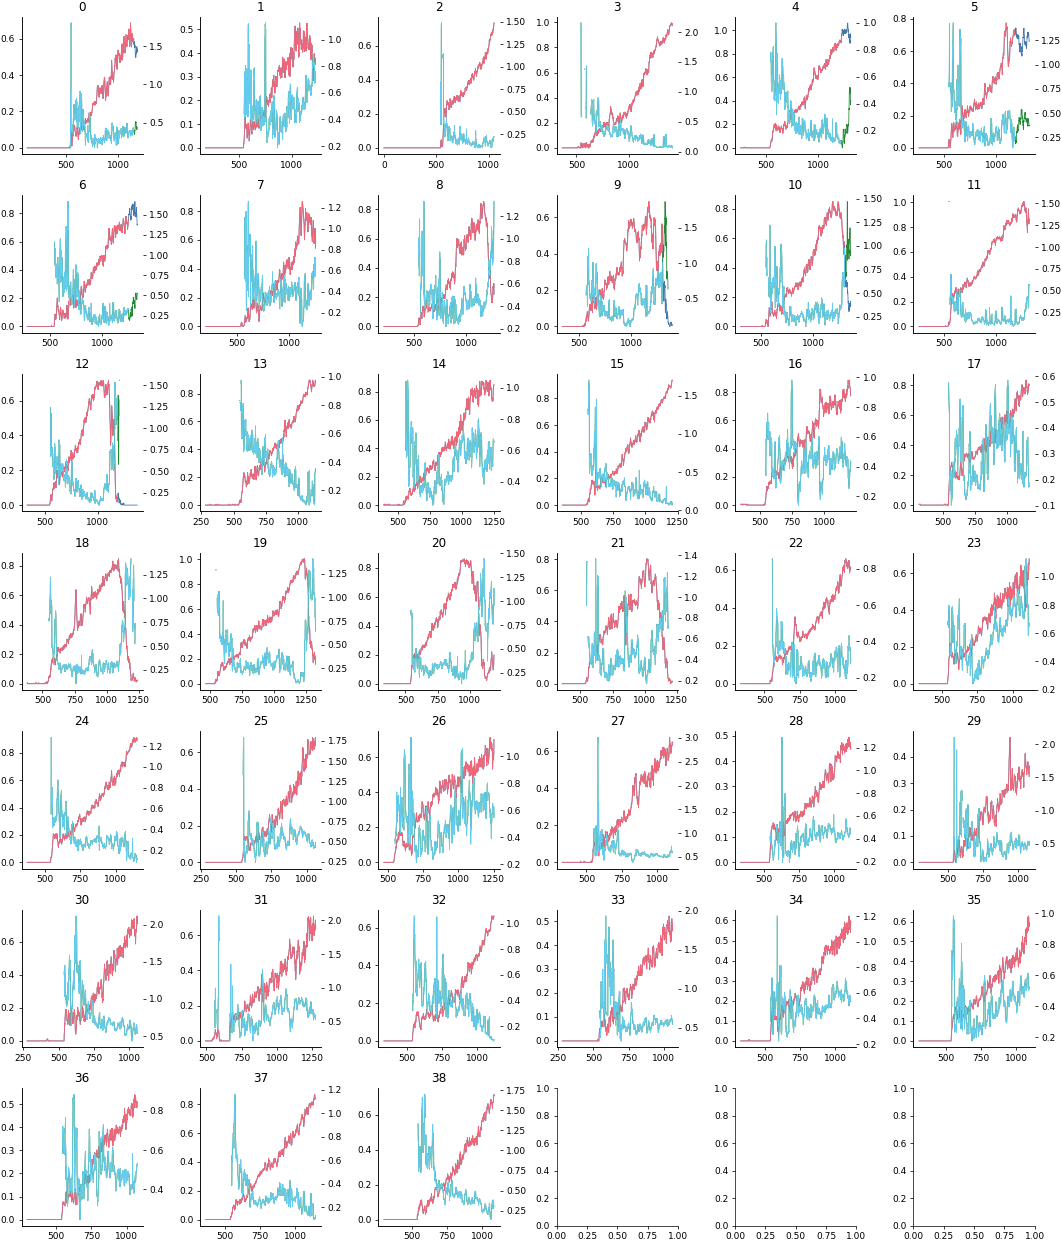

In [8]:
index_cutoffs = np.ones(aligned_covs.shape[0], dtype=int)*aligned_covs.shape[1]
index_cutoffs[0] = 1150
index_cutoffs[4] = 1220
index_cutoffs[5] = 1180
index_cutoffs[6] = 1250
index_cutoffs[9] = 1300
index_cutoffs[10] = 1300
index_cutoffs[11] = 1350
index_cutoffs[12] = 1190

fig1, axes = visualize.tile_plots_conditions(np.arange(aligned_covs.shape[0]), (2.5,2.5))
for i in range(aligned_covs.shape[0]):
    axes[i].set_title("%d" % i)
    axes[i].plot(aligned_frequencies[i,:])
    axes[i].plot(aligned_frequencies[i,:index_cutoffs[i]])
    ax2 = axes[i].twinx()
    ax2.plot(aligned_covs[i,:], color="C2")
    ax2.plot(aligned_covs[i,:index_cutoffs[i]], color="C4")
plt.tight_layout()

In [9]:
for i in range(aligned_frequencies.shape[0]):
    if index_cutoffs[i] < aligned_frequencies.shape[1]:
        aligned_frequencies[i,index_cutoffs[i]:] = np.nan
        aligned_covs[i,index_cutoffs[i]:] = np.nan

In [10]:
tnnt_covs = tnnt_moments["covs_aligned"]
tnnt_freqs = tnnt_moments["all_freqs_aligned"]

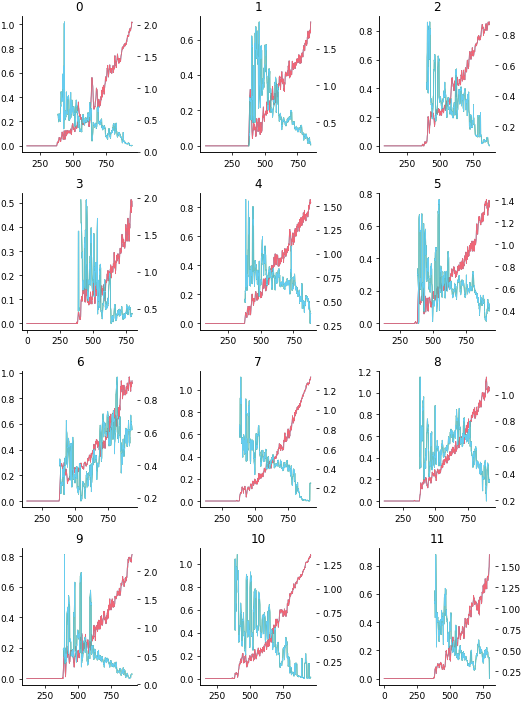

In [11]:
index_cutoffs = np.ones(tnnt_covs.shape[0], dtype=int)*tnnt_covs.shape[1]
fig1, axes = visualize.tile_plots_conditions(np.arange(tnnt_covs.shape[0]), (2.5,2.5))
for i in range(tnnt_covs.shape[0]):
    axes[i].set_title("%d" % i)
    axes[i].plot(tnnt_freqs[i,:])
    axes[i].plot(tnnt_freqs[i,:index_cutoffs[i]])
    ax2 = axes[i].twinx()
    ax2.plot(tnnt_covs[i,:], color="C2")
    ax2.plot(tnnt_covs[i,:index_cutoffs[i]], color="C4")
plt.tight_layout()

In [12]:
tnnt_ts = tnnt_moments["aligned_time_hpf"].ravel()

In [13]:
tnnt_freqs.shape

(12, 1190)

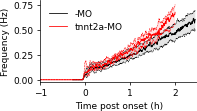

In [62]:
fig1, ax1 = plt.subplots(figsize=(3, 1.8))
# ax1.plot(time_rel_offset_freq, aligned_frequencies.T, alpha=0.2)
q1, q2, q3 = np.percentile(aligned_frequencies, (25, 50, 75), axis=0)
ax1.plot(time_rel_offset, q2, color="k", label=r"($-$)MO")
ax1.fill_between(time_rel_offset, q1, q3, color="k", alpha=0.1, lw=0, edgecolor=None)
ax1.plot(time_rel_offset, q1,color="k", lw=0.5, linestyle="--")
ax1.plot(time_rel_offset, q3,color="k", lw=0.5, linestyle="--")

q1t, q2t, q3t = np.percentile(tnnt_freqs, (25,50,75), axis=0)
ax1.plot(tnnt_ts, q2t, color="r", label=r"tnnt2a-MO")
ax1.fill_between(tnnt_ts, q1t, q3t, color="r", alpha=0.1, lw=0, edgecolor=None)
ax1.plot(tnnt_ts, q1t,color="r", lw=0.5, linestyle="--")
ax1.plot(tnnt_ts, q3t,color="r", lw=0.5, linestyle="--")

ax1.set_xlim(-1, 2.5)
ax1.set_ylim(-0.02, 0.8)
ax1.set_xlabel("Time post onset (h)")
ax1.set_ylabel("Frequency (Hz)")
ax1.set_yticks([0, 0.25, 0.5, 0.75])
ax1.legend()
plt.tight_layout()

/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


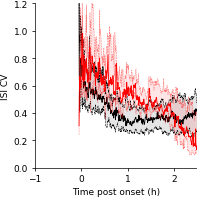

In [76]:
fig1, ax1 = plt.subplots(figsize=(3, 3))
# ax1.plot(time_rel_offset_freq, aligned_frequencies.T, alpha=0.2)
q1, q2, q3 = np.nanpercentile(aligned_covs, (25, 50, 75), axis=0)
ax1.plot(time_rel_offset, q2, color="k", label=r"($-$)MO")
ax1.fill_between(time_rel_offset, q1, q3, color="k", alpha=0.1, lw=0, edgecolor=None)
ax1.plot(time_rel_offset, q1,color="k", lw=0.5, linestyle="--")
ax1.plot(time_rel_offset, q3,color="k", lw=0.5, linestyle="--")

q1t, q2t, q3t = np.nanpercentile(tnnt_covs, (25,50,75), axis=0)
ax1.plot(tnnt_ts, q2t, color="r", label=r"tnnt2a-MO")
ax1.fill_between(tnnt_ts, q1t, q3t, color="r", alpha=0.1, lw=0, edgecolor=None)
ax1.plot(tnnt_ts, q1t,color="r", lw=0.5, linestyle="--", alpha=0.5)
ax1.plot(tnnt_ts, q3t,color="r", lw=0.5, linestyle="--", alpha=0.5)

ax1.set_xlim(-1, 2.5)
ax1.set_ylim(0,1.2)

# ax1.set_ylim(-0.02, 0.8)
ax1.set_xlabel("Time post onset (h)")
ax1.set_ylabel("ISI CV")
# ax1.set_yticks([0, 0.25, 0.5, 0.75])
# ax1.legend()
plt.tight_layout()

/tmp/ipykernel_35128/275645899.py:7: RuntimeWarning: Mean of empty slice
  mean_freq = np.nanmean(aligned_frequencies, axis=0)
/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_35128/275645899.py:7: RuntimeWarning: Mean of empty slice
  mean_freq = np.nanmean(aligned_frequencies, axis=0)
/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_35128/275645899.py:7: RuntimeWarning: Mean of empty slice
  mean_freq = np.nanmean(aligned_frequencies, axis=0)
/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/

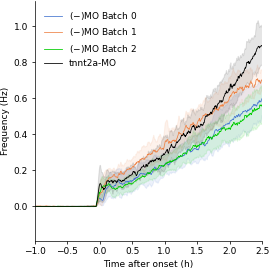

In [104]:
fig1, ax1 = plt.subplots(figsize=(4,4))
for i in range(3):
    moments = expt_moments[i]
    aligned_frequencies = moments["all_freqs_aligned"]
    all_offsets = moments["idx_offsets"]
    hpf = moments["hpf"].ravel()
    mean_freq = np.nanmean(aligned_frequencies, axis=0)
    std_freq = np.nanstd(aligned_frequencies, axis=0)
    x = (np.arange(len(mean_freq)) - np.max(all_offsets))*(hpf[1]-hpf[0])
    ax1.plot(x, mean_freq, color="C%d" % i, label=r"($-$)MO Batch %d" % i)
    ax1.fill_between(x, mean_freq-std_freq, mean_freq+std_freq, alpha=0.1, color="C%d" %i)

    ax1.set_xlabel("Time after onset (h)")

mean_tnnt2_freq = np.nanmean(tnnt_freqs, axis=0)
std_tnnt2_freq = np.nanstd(tnnt_freqs, axis=0)

ax1.plot(tnnt_ts, mean_tnnt2_freq, label="tnnt2a-MO", color="k")
ax1.fill_between(tnnt_ts, mean_tnnt2_freq-std_tnnt2_freq, mean_tnnt2_freq+std_tnnt2_freq, alpha=0.1, color="k")


ax1.set_ylabel("Frequency (Hz)")
ax1.set_xlim(-1, 2.5)
ax1.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_data_dir, "frequency_comparison.svg"))

/tmp/ipykernel_35128/3404185383.py:7: RuntimeWarning: Mean of empty slice
  mean_cov = np.nanmean(aligned_covs, axis=0)
/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_35128/3404185383.py:7: RuntimeWarning: Mean of empty slice
  mean_cov = np.nanmean(aligned_covs, axis=0)
/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_35128/3404185383.py:7: RuntimeWarning: Mean of empty slice
  mean_cov = np.nanmean(aligned_covs, axis=0)
/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_35128/3

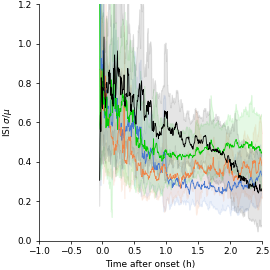

In [103]:
fig1, ax1 = plt.subplots(figsize=(4,4))
for i in range(3):
    moments = expt_moments[i]   
    aligned_covs = moments["covs_aligned"]
    all_offsets = moments["idx_offsets"]
    hpf = moments["hpf"].ravel()
    mean_cov = np.nanmean(aligned_covs, axis=0)
    std_cov = np.nanstd(aligned_covs, axis=0)
    x = (np.arange(len(mean_cov)) - np.max(all_offsets))*(hpf[1]-hpf[0])
    ax1.plot(x, mean_cov, color="C%d" % i)
    ax1.fill_between(x, mean_cov-std_cov, mean_cov+std_cov, alpha=0.1, color="C%d" %i)

    ax1.set_xlabel("Time after onset (h)")
    
mean_tnnt2_freq = np.nanmean(tnnt_covs, axis=0)
std_tnnt2_freq = np.nanstd(tnnt_covs, axis=0)

ax1.plot(tnnt_ts, mean_tnnt2_freq, label="tnnt2a-MO", color="k")
ax1.fill_between(tnnt_ts, mean_tnnt2_freq-std_tnnt2_freq, mean_tnnt2_freq+std_tnnt2_freq, alpha=0.1, color="k")
ax1.set_ylim(0,1.2)
ax1.set_xlim(-1, 2.5)
ax1.set_ylabel(r"ISI $\sigma/\mu$")
plt.tight_layout()
plt.savefig(os.path.join(output_data_dir, "cv_comparison.svg"))

In [20]:
all_hpf_starts = []
for moments in expt_moments:
    all_offsets = moments["idx_offsets"]
    hpf = moments["hpf"].ravel()
    print(all_offsets)
    print(len(hpf))
    moments["hpf_start"] = hpf[all_offsets].tolist()[0]
    all_hpf_starts.extend(moments["hpf_start"])
bins = np.linspace(np.min(all_hpf_starts), np.max(all_hpf_starts), 20)

[[418 373 550 186 290 288 268 348 334 209 243 289 224]]
1052
[[268 156 197 200 236 169  84 218 191]]
857
[[219 213 177 268  79 222 215 253 273  57 212 271 221 238 256 186 247]]
782


In [21]:
control_hpf_starts_dfs = []
for idx, moments in enumerate(expt_moments):
    hpf_start = moments["hpf_start"]
    curr_df = pd.DataFrame({"experiment": [expts[idx]]*len(hpf_start),
                            "condition": ["uninjected"]*len(hpf_start),
                           "embryo": np.arange(len(hpf_start)),
                           "start_hpf": hpf_start})
    control_hpf_starts_dfs.append(curr_df)

In [22]:
control_hpf_start = pd.concat(control_hpf_starts_dfs, axis=0)

In [24]:
control_hpf_start.to_csv(output_datadir/"../all_uninjected_widefield_start_hpfs.csv")

In [15]:
tnnt_hpf_starts = tnnt_moments["hpf"].ravel()[tnnt_moments["idx_offsets"]].tolist()[0]

In [16]:
tnnt_hpf = pd.DataFrame({"experiment": [expt_dir_name]*len(tnnt_hpf_starts), 
                         "condition": ["tnnt2a_mo"]* len(tnnt_hpf_starts),
                         "embryo": np.arange(len(tnnt_hpf_starts)),
                         "start_hpf": tnnt_hpf_starts})

In [18]:
tnnt_hpf.to_csv(output_datadir/"start_hpfs.csv")

In [19]:
hpf_starts = []
for moments in expt_moments:
    all_offsets = moments["idx_offsets"]
    hpf = moments["hpf"].ravel()
    hpf_starts.extend(hpf[all_offsets].tolist()[0])

In [21]:
moments

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Thu Nov 10 10:25:33 2022',
 '__version__': '1.0',
 '__globals__': [],
 'idx_offsets': array([[219, 213, 177, 268,  79, 222, 215, 253, 273,  57, 212, 271, 221,
         238, 256, 186, 247]]),
 'all_freqs': array([[0.        , 0.        , 0.        , ..., 0.60990888, 0.61571754,
         0.60990888],
        [0.        , 0.        , 0.        , ..., 0.65637813, 0.65056948,
         0.67961276],
        [0.        , 0.        , 0.        , ..., 0.90615034, 0.90615034,
         0.90615034],
        ...,
        [0.        , 0.        , 0.        , ..., 0.49373576, 0.50535308,
         0.51116173],
        [0.        , 0.        , 0.        , ..., 0.84806378, 0.84225513,
         0.83644647],
        [0.        , 0.        , 0.        , ..., 0.71446469, 0.71446469,
         0.70865604]]),
 'all_freqs_aligned': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ...,

In [20]:
hpf_starts

[21.14901960784365,
 20.928431372549475,
 21.796078431373225,
 20.01176470588258,
 20.521568627451337,
 20.511764705882705,
 20.413725490196406,
 20.8058823529416,
 20.737254901961194,
 20.124509803921825,
 20.291176470588532,
 20.51666666666702,
 20.19803921568655,
 20.422058823529742,
 19.873039215686465,
 20.07401960784338,
 20.088725490196325,
 20.26519607843166,
 19.93676470588256,
 19.52009803921579,
 20.176960784313994,
 20.044607843137488,
 20.173529411764974,
 20.144117647059083,
 19.967647058823747,
 20.413725490196406,
 19.48725490196088,
 20.18823529411792,
 20.153921568627716,
 20.34019607843168,
 20.43823529411798,
 19.379411764705953,
 20.13921568627477,
 20.42843137254935,
 20.183333333333604,
 20.266666666666957,
 20.354901960784627,
 20.01176470588258,
 20.310784313725794]

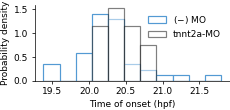

In [102]:
bins = np.linspace(np.min(all_hpf_starts), np.max(all_hpf_starts), 12)
mean_hpf = np.mean(hpf_starts)
fig1, ax1 = plt.subplots(figsize=(3.5,1.4))
ax1.hist(hpf_starts, linewidth=1.2, bins=bins, edgecolor="#539ad3", facecolor="white", density=True, label="($-$) MO")
ax1.hist(tnnt_hpf_starts, linewidth=1.2, bins=bins, edgecolor="k", facecolor="white", alpha=0.5, density=True, label="tnnt2a-MO")
# ymin, ymax = ax1.get_ylim()
# ax1.vlines(mean_hpf, ymin=ymin, ymax=ymax, linewidth=1.5, color="#A91F23")
# ax1.text(mean_hpf+0.05, ymax*0.95, r"$\mu = %.1f\ \mathrm{hpf}$" % mean_hpf, color="#A91F23")
# ax1.text(21.5, 10, r"$n = %d$" % len(hpf_starts))
ax1.legend()
ax1.set_xlabel("Time of onset (hpf)")
ax1.set_ylabel("Probability density")
plt.savefig(os.path.join(output_data_dir, "initiation_time_comparison.svg"))